# 🎮 1D Playground: Diffusion & Flow Matching Sanity Checks

This notebook provides interactive 1D experiments to build intuition for diffusion models and flow matching.

**Why 1D?**
- Ultra-fast training (in seconds & CPU friendly)
- Easy to visualize distributions and flows
- Perfect for debugging and understanding

**Note:** You should be able to use this notebook with CPU only machines.

If you are using VSCode and you do not see your venv in the kernel options, first activate your venv in your terminal and run 

'''

uv run --active python -m ipykernel install --user --name cmu-10799 --display-name "Python (cmu-10799)"

'''

In VS Code:
- Command Palette → Python: Select Interpreter → pick .venv-(your env)/bin/python
- In the notebook → Select Kernel → pick .venv-(your env) or Python (cmu-10799-cpu)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Create 1D Mixture of Gaussians

In [2]:
def get_1d_data(name, n_samples=10000):
    """Generate 1D mixture of Gaussians datasets with different weights."""
    if name == '2gaussians':
        # Two Gaussians at -2 and 2 (equal weights)
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.5, 0.5]
    elif name == '3gaussians':
        # Three Gaussians at -2, 0, 2 (equal weights)
        centers = [-2.0, 0.0, 2.0]
        std = 0.3
        weights = [1/3, 1/3, 1/3]
    elif name == '5gaussians':
        # Five evenly spaced Gaussians (equal weights)
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.2, 0.2, 0.2, 0.2, 0.2]
    elif name == 'uneven':
        # Uneven mixture with different spacing (equal weights)
        centers = [-3.5, -1.0, 0.5, 2.5]
        std = 0.3
        weights = [0.25, 0.25, 0.25, 0.25]
    elif name == 'wide':
        # Wider Gaussians (equal weights)
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.5, 0.5]
    elif name == 'weighted2':
        # Two Gaussians with different weights (tall left, short right)
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.8, 0.2]
    elif name == 'weighted3':
        # Three Gaussians with different weights (tall-short-medium)
        centers = [-2.5, 0.0, 2.5]
        std = 0.3
        weights = [0.5, 0.2, 0.3]
    elif name == 'weighted5':
        # Five Gaussians with varied weights
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.1, 0.15, 0.4, 0.25, 0.1]
    elif name == 'weighted_wide':
        # Wider Gaussians (unequal weights)
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.65, 0.35]
    else:
        raise ValueError(f"Unknown dataset: {name}")
    
    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    # Sample from each Gaussian according to weights
    X = []
    for center, weight in zip(centers, weights):
        n_samples_for_center = int(n_samples * weight)
        samples = np.random.randn(n_samples_for_center, 1) * std + center
        X.append(samples)
    X = np.concatenate(X, axis=0)
    
    # Shuffle
    np.random.shuffle(X)
    
    return torch.tensor(X, dtype=torch.float32)


def get_ground_truth_density(name, x_values):
    """Compute the ground truth density for a given dataset at x_values."""
    if name == '2gaussians':
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.5, 0.5]
    elif name == '3gaussians':
        centers = [-2.0, 0.0, 2.0]
        std = 0.3
        weights = [1/3, 1/3, 1/3]
    elif name == '5gaussians':
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.2, 0.2, 0.2, 0.2, 0.2]
    elif name == 'uneven':
        centers = [-3.5, -1.0, 0.5, 2.5]
        std = 0.3
        weights = [0.25, 0.25, 0.25, 0.25]
    elif name == 'wide':
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.5, 0.5]
    elif name == 'weighted2':
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.8, 0.2]
    elif name == 'weighted3':
        centers = [-2.5, 0.0, 2.5]
        std = 0.3
        weights = [0.5, 0.2, 0.3]
    elif name == 'weighted5':
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.1, 0.15, 0.4, 0.25, 0.1]
    elif name == 'weighted_wide':
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.65, 0.35]
    else:
        raise ValueError(f"Unknown dataset: {name}")
    
    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    # Compute mixture of Gaussians density
    density = np.zeros_like(x_values)
    for center, weight in zip(centers, weights):
        density += weight * (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - center) / std) ** 2)
    
    return density

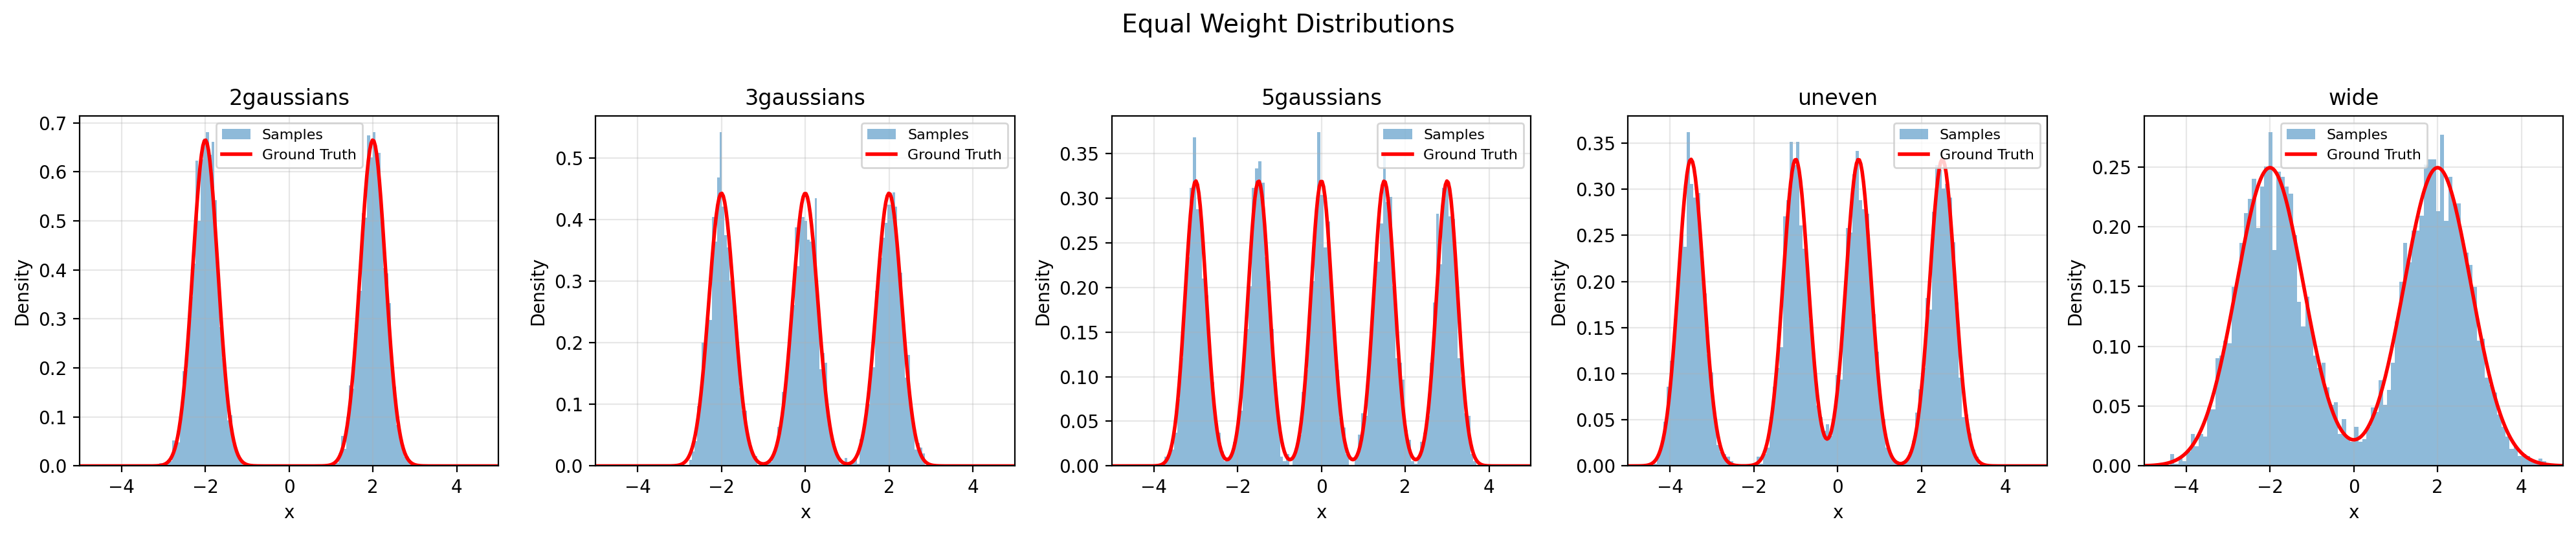

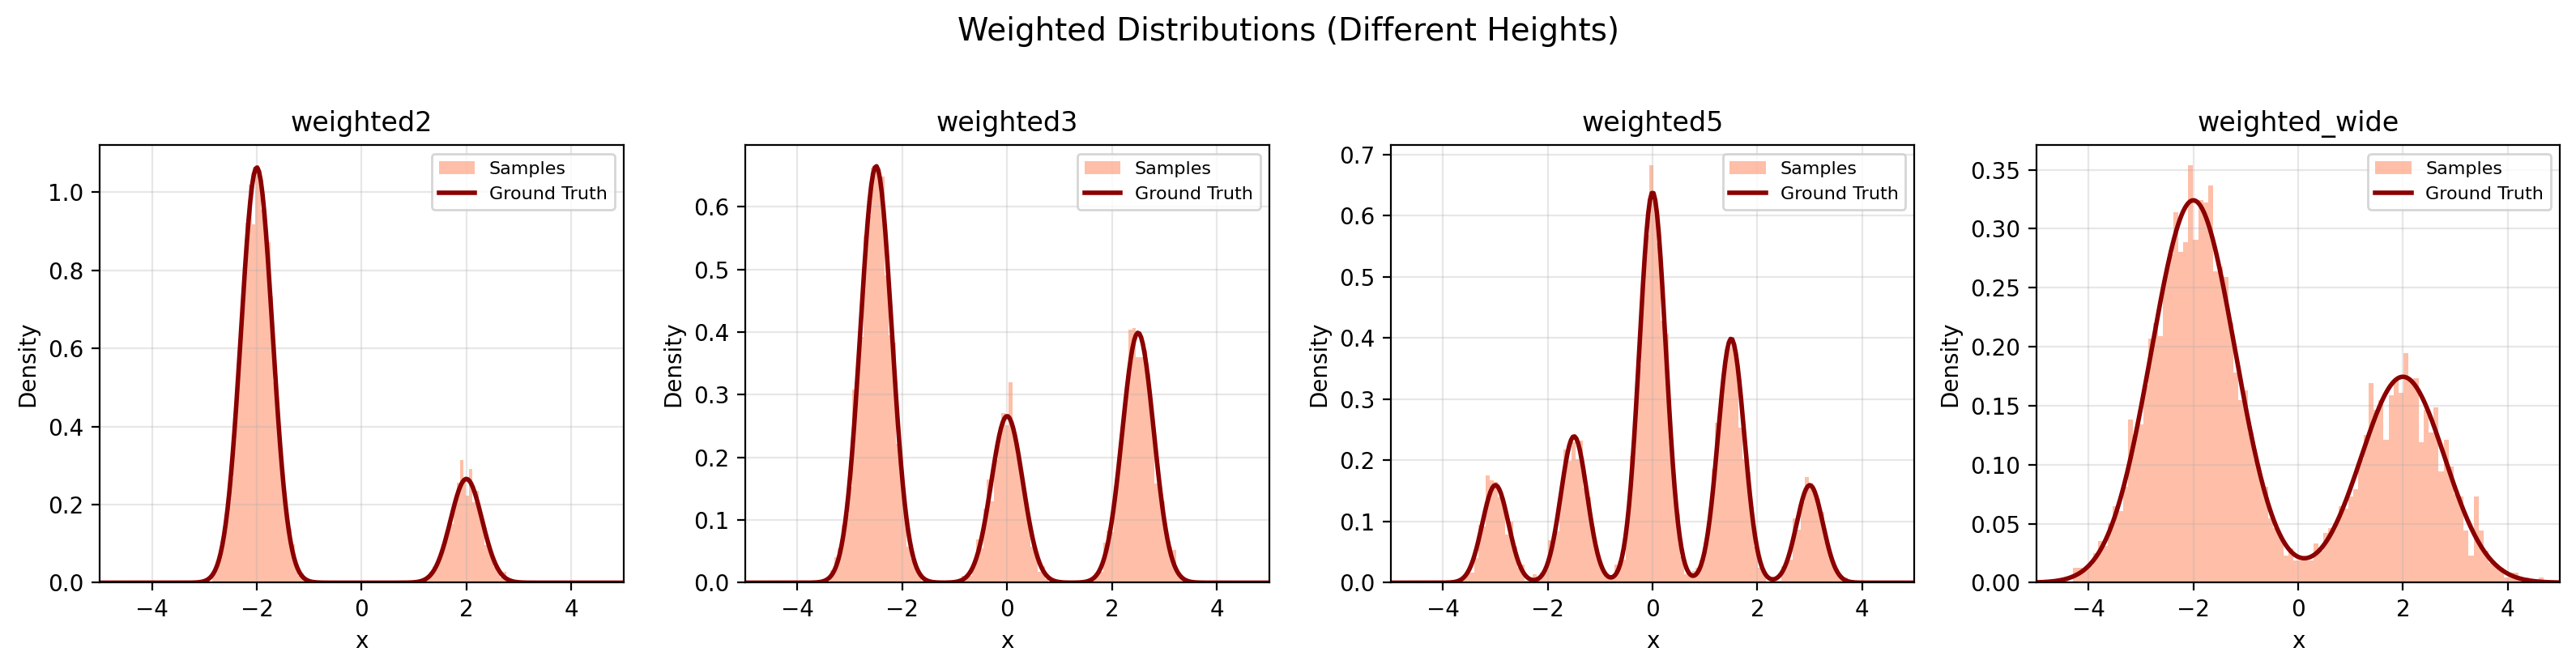

In [3]:
# Visualize available distributions
datasets_equal = ['2gaussians', '3gaussians', '5gaussians', 'uneven', 'wide']
datasets_weighted = ['weighted2', 'weighted3', 'weighted5', 'weighted_wide']

# Plot equal weight distributions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Equal Weight Distributions', fontsize=14, y=1.02)
for ax, name in zip(axes, datasets_equal):
    data = get_1d_data(name, n_samples=5000)
    ax.hist(data.numpy(), bins=100, density=True, alpha=0.5, label='Samples')
    
    # Overlay ground truth
    x_line = np.linspace(-5, 5, 300)
    density = get_ground_truth_density(name, x_line)
    ax.plot(x_line, density, 'r-', linewidth=2, label='Ground Truth')
    
    ax.set_title(name)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Plot weighted distributions
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Weighted Distributions (Different Heights)', fontsize=14, y=1.02)
for ax, name in zip(axes, datasets_weighted):
    data = get_1d_data(name, n_samples=5000)
    ax.hist(data.numpy(), bins=100, density=True, alpha=0.5, color='coral', label='Samples')
    
    # Overlay ground truth
    x_line = np.linspace(-5, 5, 300)
    density = get_ground_truth_density(name, x_line)
    ax.plot(x_line, density, 'darkred', linewidth=2, label='Ground Truth')
    
    ax.set_title(name)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

## 2. Simple network for 1D

First design a simple network (like an MLP) to model the 1D data, remember to also include the time embeddings.

In [4]:
# ## 2. Simple network for 1D
# import math
# import torch.nn as nn

# class SinusoidalPositionEmbeddings(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, time):
#         device = time.device
#         half_dim = self.dim // 2
#         embeddings = math.log(10000) / (half_dim - 1)
#         embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
#         embeddings = time[:, None] * embeddings[None, :]
#         embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
#         return embeddings

# class SimpleMLP(nn.Module):
#     def __init__(self, hidden_size=128, data_dim=1):
#         super().__init__()
        
#         # Time embedding layer
#         self.time_mlp = nn.Sequential(
#             SinusoidalPositionEmbeddings(hidden_size),
#             nn.Linear(hidden_size, hidden_size),
#             nn.GELU()
#         )
        
#         # Main network
#         self.input_mlp = nn.Sequential(
#             nn.Linear(data_dim, hidden_size),
#             nn.GELU()
#         )
        
#         self.middle_mlp = nn.Sequential(
#             nn.Linear(hidden_size, hidden_size),
#             nn.GELU(),
#             nn.Linear(hidden_size, hidden_size),
#             nn.GELU()
#         )
        
#         self.output_layer = nn.Linear(hidden_size, data_dim)

#     def forward(self, x, t):
#         # Embed time
#         t_emb = self.time_mlp(t)
        
#         # Embed input
#         x_emb = self.input_mlp(x)
        
#         # Combine (simple addition is standard for diffusion MLPs)
#         h = x_emb + t_emb
        
#         # Process
#         h = self.middle_mlp(h)
#         return self.output_layer(h)

# # Initialize model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# mlp_model = SimpleMLP(hidden_size=128).to(device)
# print("Model created.")

class RobustMLP(nn.Module):
    def __init__(self, hidden_size=256, data_dim=1):
        super().__init__()
        
        # We use a simple Concat approach for 1D data.
        # It's often more stable for "Toy" 1D problems than Sinusoidal embeddings.
        self.net = nn.Sequential(
            # Input: x (1) + t (1) = 2
            nn.Linear(data_dim + 1, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, data_dim)
        )

    def forward(self, x, t):
        # x: (B, 1)
        # t: (B,) -> We need to shape it to (B, 1)
        
        # Normalize t to [0, 1] range for the MLP if it's not already
        # (The flow matching class scales it to 1000, so we scale it back for this specific MLP)
        # This makes optimization easier (inputs roughly -1 to 1)
        t_norm = t.view(-1, 1) / 1000.0 
        
        # Concatenate x and t
        xt = torch.cat([x, t_norm], dim=1)
        
        return self.net(xt)
    
mlp_model = RobustMLP(hidden_size=512).to(device)
print("Robust MLP model created.")

Robust MLP model created.


## 3. Flow Matching algorithm implementation


In [5]:
"""
Flow Matching (1D Compatible)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Tuple, Optional, List

class FlowMatching(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        num_timesteps: int = 1000, 
        **kwargs
    ):
        super().__init__()
        self.model = model
        self.device = device
        # Scaling factor for Sinusoidal Embeddings (matches DDPM training scale)
        self.num_timesteps = int(num_timesteps)

    def compute_loss(self, x_1: torch.Tensor, ot_coupling: bool = False, **kwargs) -> Tuple[torch.Tensor, Dict[str, float]]:
        """
        Computes the Flow Matching loss.
        """
        batch_size = x_1.shape[0]
        x_1 = x_1.to(self.device)
        
        # 1. Sample noise x_0 ~ N(0, I)
        x_0 = torch.randn_like(x_1)
        
        # === OPTIMAL TRANSPORT FIX ===
        # In 1D, sorting both creates the optimal coupling (Wasserstein distance).
        # This prevents trajectories from crossing (e.g. left noise going right, right noise going left).
        if ot_coupling:
            # We treat the batch dimension as the samples to sort
            # For 1D data (B, 1), we sort along dim 0
            x_0, _ = torch.sort(x_0, dim=0)
            x_1, _ = torch.sort(x_1, dim=0)
        # =============================
        
        # 2. Sample time t uniformly [0, 1]
        t = torch.rand((batch_size,), device=self.device)
        
        # 3. Compute x_t (Linear Interpolation)
        # Fix: Dynamic reshaping to handle (B, 1) or (B, C, H, W)
        view_shape = (batch_size,) + (1,) * (x_1.ndim - 1)
        t_reshaped = t.view(*view_shape)
        
        x_t = t_reshaped * x_1 + (1.0 - t_reshaped) * x_0
        
        # 4. Compute target velocity
        v_target = x_1 - x_0
        
        # 5. Predict velocity
        # Scale t from [0, 1] -> [0, 1000] for the Sinusoidal Embeddings
        t_scaled = t * self.num_timesteps 
        v_pred = self.model(x_t, t_scaled)
        
        # 6. MSE Loss
        loss = F.mse_loss(v_pred, v_target)
        metrics = {'loss': float(loss.item())}
        
        return loss, metrics

    @torch.no_grad()
    def sample(
        self,
        batch_size: int,
        image_shape: Tuple[int, ...],
        verbose: bool = True,
        num_steps: Optional[int] = None,
        **kwargs
    ) -> List[torch.Tensor]:
        """
        Generates samples using Euler integration.
        Returns full history [noise, ..., data].
        """
        self.model.eval()
        device = self.device
        
        # Default to fewer steps for sampling if not specified (e.g. 100)
        # Flow Matching allows much faster sampling than training scale!
        if num_steps is None:
            num_steps = 100 
            
        # 1. Start from pure noise (t=0)
        x = torch.randn((batch_size, *image_shape), device=device)
        
        history = [x.cpu()]
        
        # Define step size dt
        dt = 1.0 / num_steps
        
        iterator = range(num_steps)
        if verbose:
            iterator = tqdm(iterator, desc="Flow Matching Sampling", total=num_steps)
            
        # 2. Euler Integration Loop (t goes 0 -> 1)
        for i in iterator:
            # Current time t
            t_value = i / num_steps
            t_batch = torch.full((batch_size,), t_value, device=device)
            
            # Predict velocity (Scaled t)
            t_scaled = t_batch * self.num_timesteps
            v_pred = self.model(x, t_scaled)
            
            # Update x: x_{next} = x + v * dt
            x = x + v_pred * dt
            
            history.append(x.cpu())
            
        return history

## 4. Training

Write your training loop here (or you can combine it above, whichever way is easier for you)

Starting Flow Matching training on cuda...
Iter 0: Loss = 0.2397
Iter 50: Loss = 0.0275
Iter 100: Loss = 0.0389
Iter 150: Loss = 0.0235
Iter 200: Loss = 0.0143
Iter 250: Loss = 0.0218
Iter 300: Loss = 0.0188
Iter 350: Loss = 0.0178
Iter 400: Loss = 0.0173
Iter 450: Loss = 0.0284
Iter 500: Loss = 0.0197
Iter 550: Loss = 0.0173
Iter 600: Loss = 0.0195
Iter 650: Loss = 0.0331
Iter 700: Loss = 0.0161
Iter 750: Loss = 0.0149
Iter 800: Loss = 0.0264
Iter 850: Loss = 0.0096
Iter 900: Loss = 0.0122
Iter 950: Loss = 0.0109
Iter 1000: Loss = 0.0104
Iter 1050: Loss = 0.0126
Iter 1100: Loss = 0.0100
Iter 1150: Loss = 0.0133
Iter 1200: Loss = 0.0132
Iter 1250: Loss = 0.0118
Iter 1300: Loss = 0.0092
Iter 1350: Loss = 0.0089
Iter 1400: Loss = 0.0095
Iter 1450: Loss = 0.0173
Iter 1500: Loss = 0.0097
Iter 1550: Loss = 0.0177
Iter 1600: Loss = 0.0132
Iter 1650: Loss = 0.0079
Iter 1700: Loss = 0.0124
Iter 1750: Loss = 0.0078
Iter 1800: Loss = 0.0054
Iter 1850: Loss = 0.0204
Iter 1900: Loss = 0.0124
Iter 

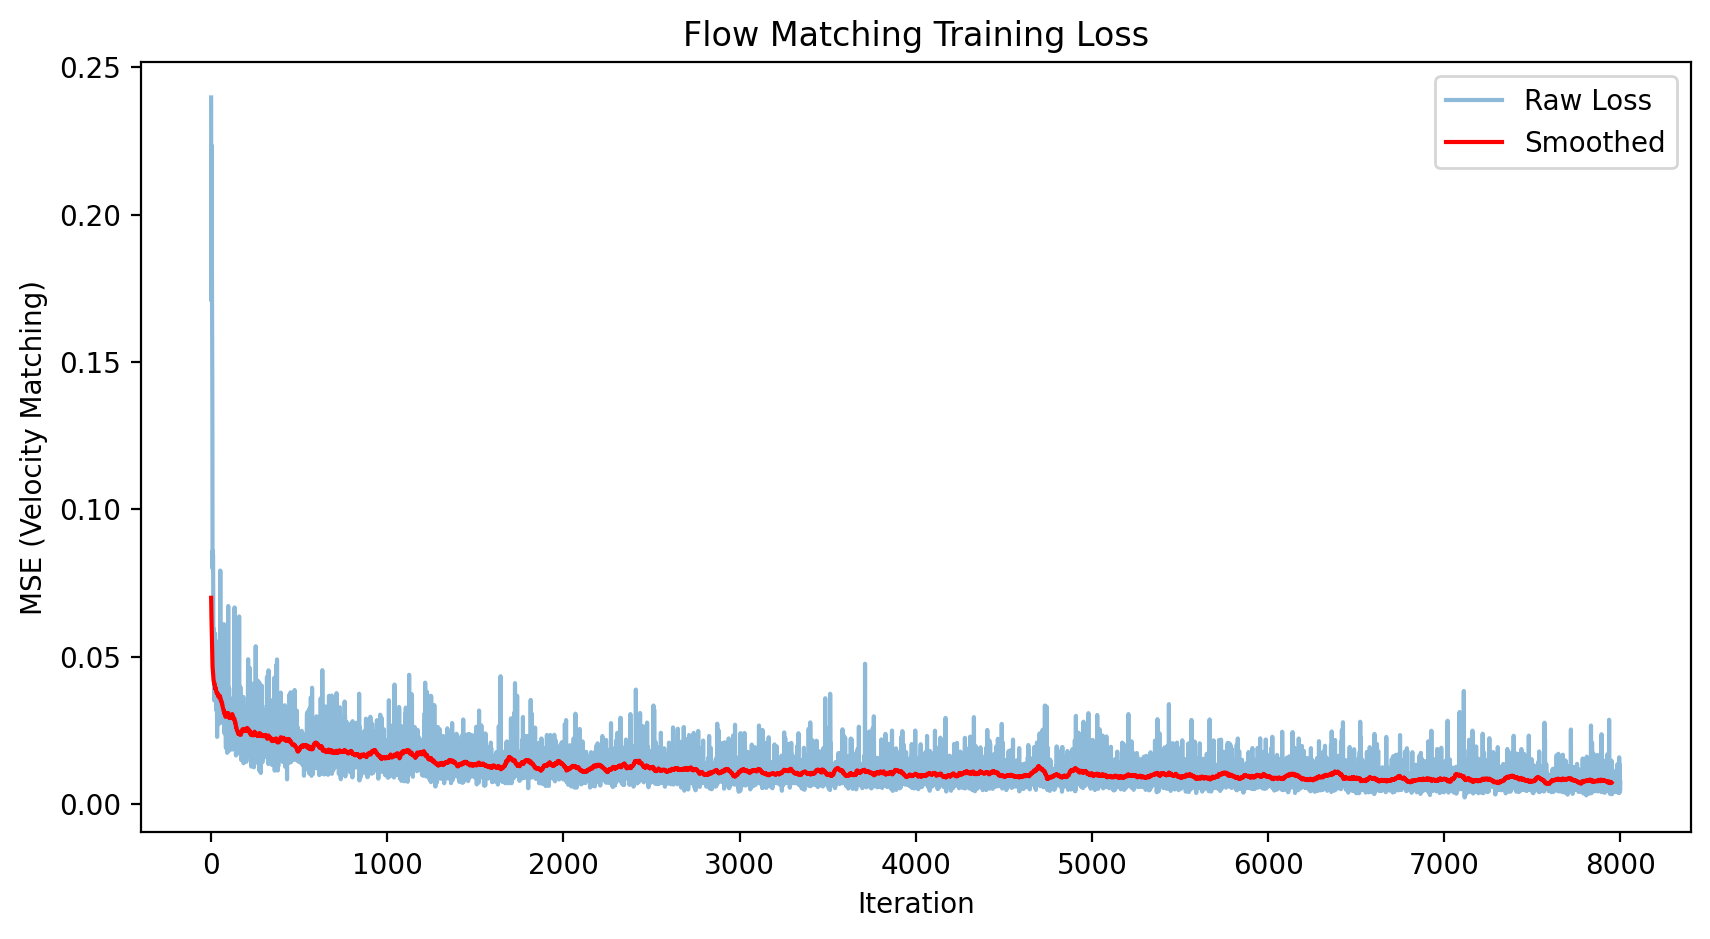

In [6]:
## 4. Training

# === CONFIGURATION ===
# Options: '2gaussians', '3gaussians', '5gaussians', 'uneven', 'wide', etc.
DATASET_NAME = '5gaussians' 
# =====================

# 1. Setup Flow Matching
# Note: We use 1000 timesteps for embedding scaling, same as DDPM
flow_model = FlowMatching(
    model=mlp_model,
    device=device,
    num_timesteps=1000 
)
flow_model = flow_model.to(device)

# 2. Optimizer
optimizer = torch.optim.Adam(flow_model.model.parameters(), lr=1e-4)

# 3. Training Loop
num_iterations = 8000
batch_size = 256
logging_interval = 50

print(f"Starting Flow Matching training on {device}...")
loss_history = []

flow_model.train()
for i in range(num_iterations):
    optimizer.zero_grad()
    
    # Get batch
    x_1 = get_1d_data(DATASET_NAME, n_samples=batch_size).to(device)
    
    # Normalize data to roughly [-1, 1] or similar standard range
    # Our data is centered at 0 with spread ~3-4, so dividing by 4 is good
    x_1 = x_1 / 4.0
    
    # Compute Loss
    loss, metrics = flow_model.compute_loss(x_1, ot_coupling=True)
    # without OT coupling:
    #loss, metrics = flow_model.compute_loss(x_1, ot_coupling=False)
    
    # Backward
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if i % logging_interval == 0:
        print(f"Iter {i}: Loss = {loss.item():.4f}")

print("Training finished.")

# Optional: Plot loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, alpha=0.5, label='Raw Loss')
# Plot smoothed loss
smoothed = np.convolve(loss_history, np.ones(50)/50, mode='valid')
plt.plot(smoothed, color='red', label='Smoothed')
plt.title("Flow Matching Training Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE (Velocity Matching)")
plt.legend()
plt.show()

## 5. Visualize Samples

Visualize your learned distributions and compare them with the ground truth. I have left my visualization results for you as reference.

Sampling...


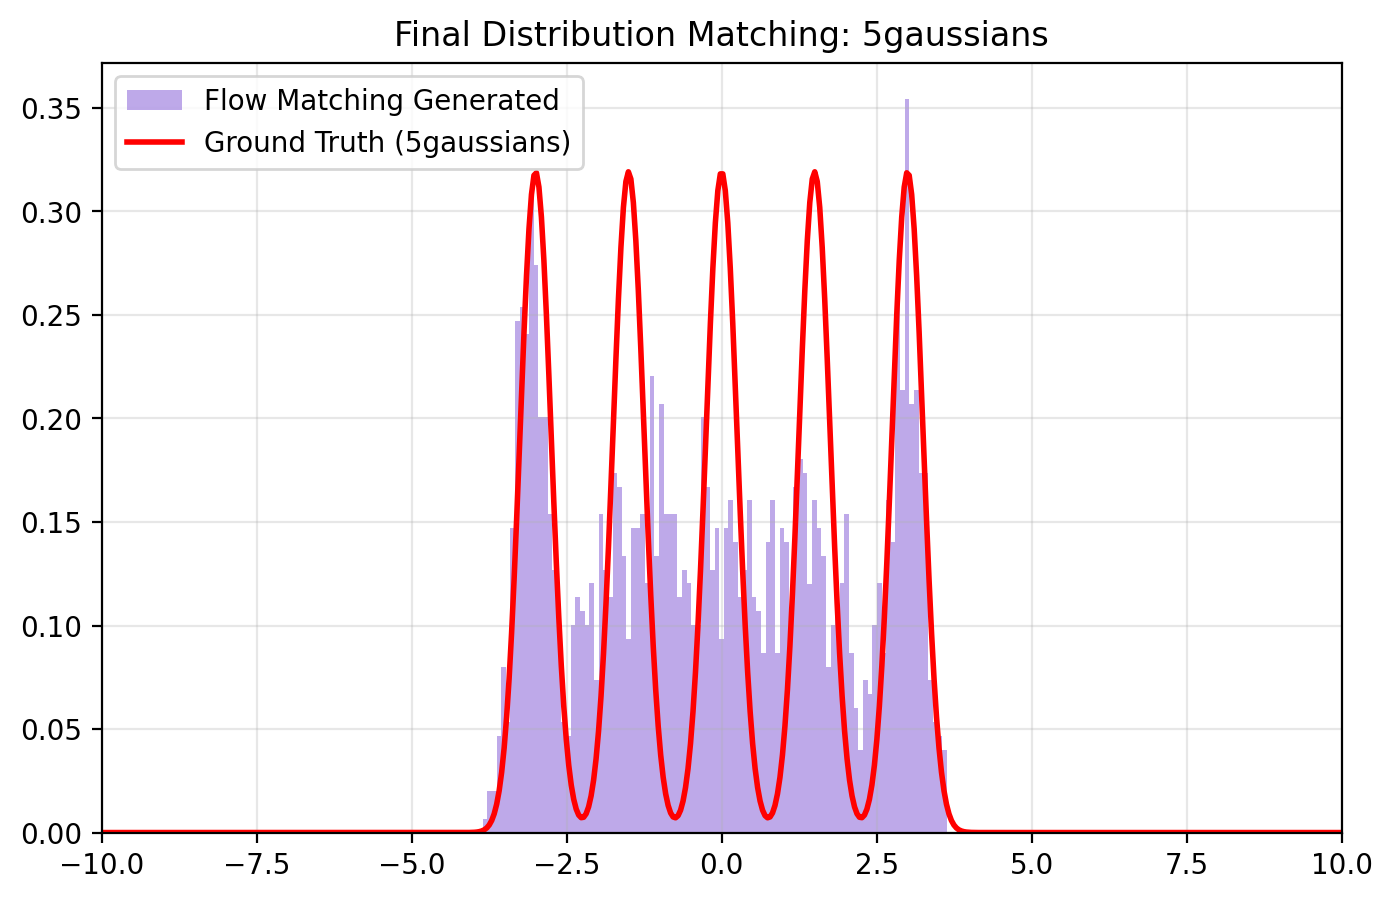

In [7]:
## 5. Visualize Samples

# 1. Generate Final Samples
print("Sampling...")
# Flow Matching allows fewer steps! Try 50 or 100.
trajectory = flow_model.sample(batch_size=2000, image_shape=(1,), num_steps=100, verbose=False)

# In Flow Matching, the loop goes 0->1, so the last element is the data
final_samples = trajectory[-1].numpy().flatten()

# 2. Un-normalize to original scale
final_samples = final_samples * 4.0

# 3. Setup Ground Truth Line
x_line = np.linspace(-10, 10, 500)
gt_density = get_ground_truth_density(DATASET_NAME, x_line)

# 4. Plot
plt.figure(figsize=(8, 5))
plt.hist(final_samples, bins=100, density=True, alpha=0.6, color='mediumpurple', label='Flow Matching Generated')
plt.plot(x_line, gt_density, 'r-', linewidth=2, label=f'Ground Truth ({DATASET_NAME})')
plt.title(f'Final Distribution Matching: {DATASET_NAME}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-10, 10)
plt.show()

## 6. Visualize Sampling Trajectories

Besides visualizing the final results, you can also visualize the entire sampling trajectory in order to get a better understanding of the process. Here I also left you my visualization results as an example.

Generating trajectory...


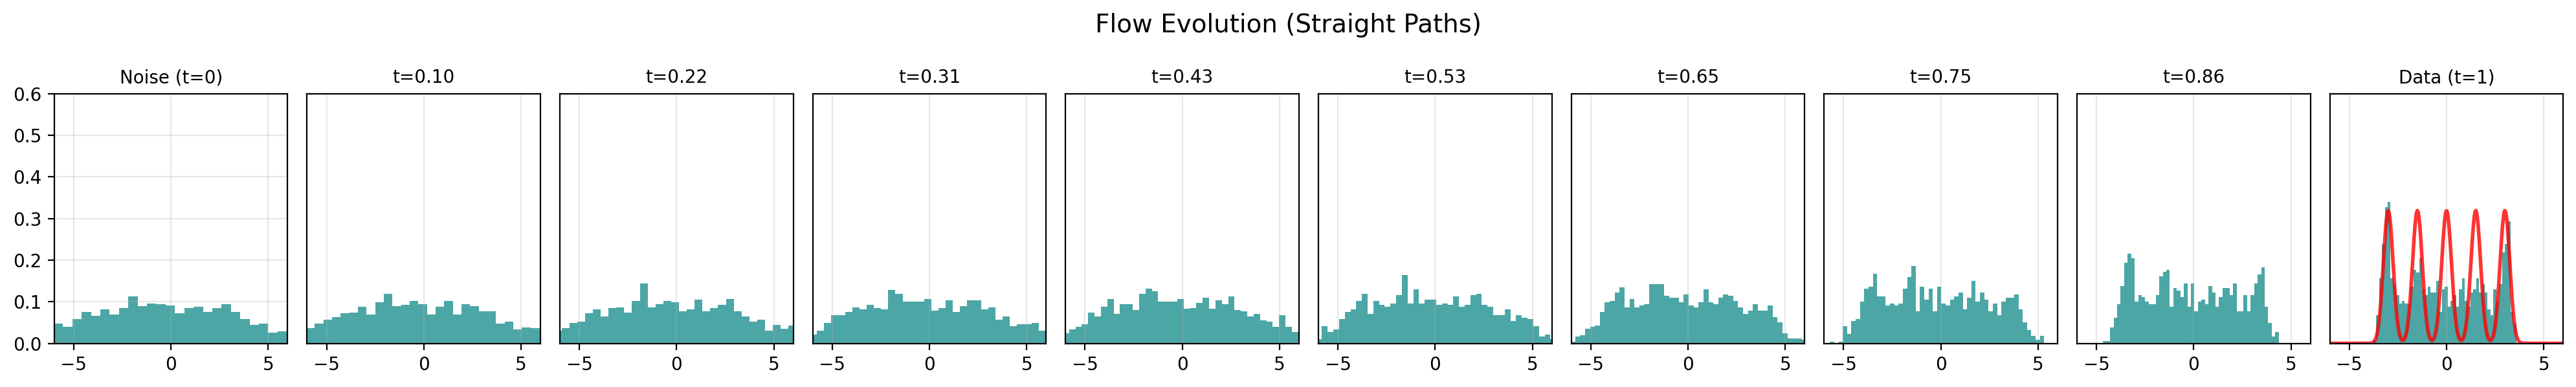

In [8]:
### CELL 6 - VISUALISE SAMPLING TRAJECTORY 

def plot_trajectory(trajectory, title, n_points=1000, n_steps_show=10, dataset_name=None):
    """Plot sampling trajectory."""
    n_total_steps = len(trajectory)
    
    # Pick time steps to visualize
    step_indices = np.linspace(0, n_total_steps-1, n_steps_show, dtype=int)
    
    fig, axes = plt.subplots(1, n_steps_show, figsize=(2*n_steps_show, 3))
    
    # Prepare ground truth
    if dataset_name is not None:
        x_line = np.linspace(-6, 6, 300)
        gt_density = get_ground_truth_density(dataset_name, x_line)
    
    for ax, step_idx in zip(axes, step_indices):
        # Un-normalize for visualization
        points = trajectory[step_idx][:n_points].flatten() * 4.0
        
        ax.hist(points.numpy(), bins=50, density=True, alpha=0.7, color='teal')
        
        # Overlay ground truth on final step
        if dataset_name is not None and step_idx == step_indices[-1]:
            ax.plot(x_line, gt_density, 'r-', linewidth=2, alpha=0.8)
        
        ax.set_xlim(-6, 6)
        ax.set_ylim(0, 0.6)
        
        # Flow Matching goes 0->1, so step_idx 0 is Noise, -1 is Data
        if step_idx == 0:
            label = "Noise (t=0)"
        elif step_idx == step_indices[-1]:
            label = "Data (t=1)"
        else:
            label = f"t={step_idx/n_total_steps:.2f}"
            
        ax.set_title(label, fontsize=10)
        
        if ax != axes[0]:
            ax.set_yticks([])
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Run it
print("Generating trajectory...")
# We use sample() which returns the history list
trajectory = flow_model.sample(batch_size=1000, image_shape=(1,), num_steps=50, verbose=False)

plot_trajectory(trajectory, f"Flow Evolution (Straight Paths)", n_steps_show=10, dataset_name=DATASET_NAME)

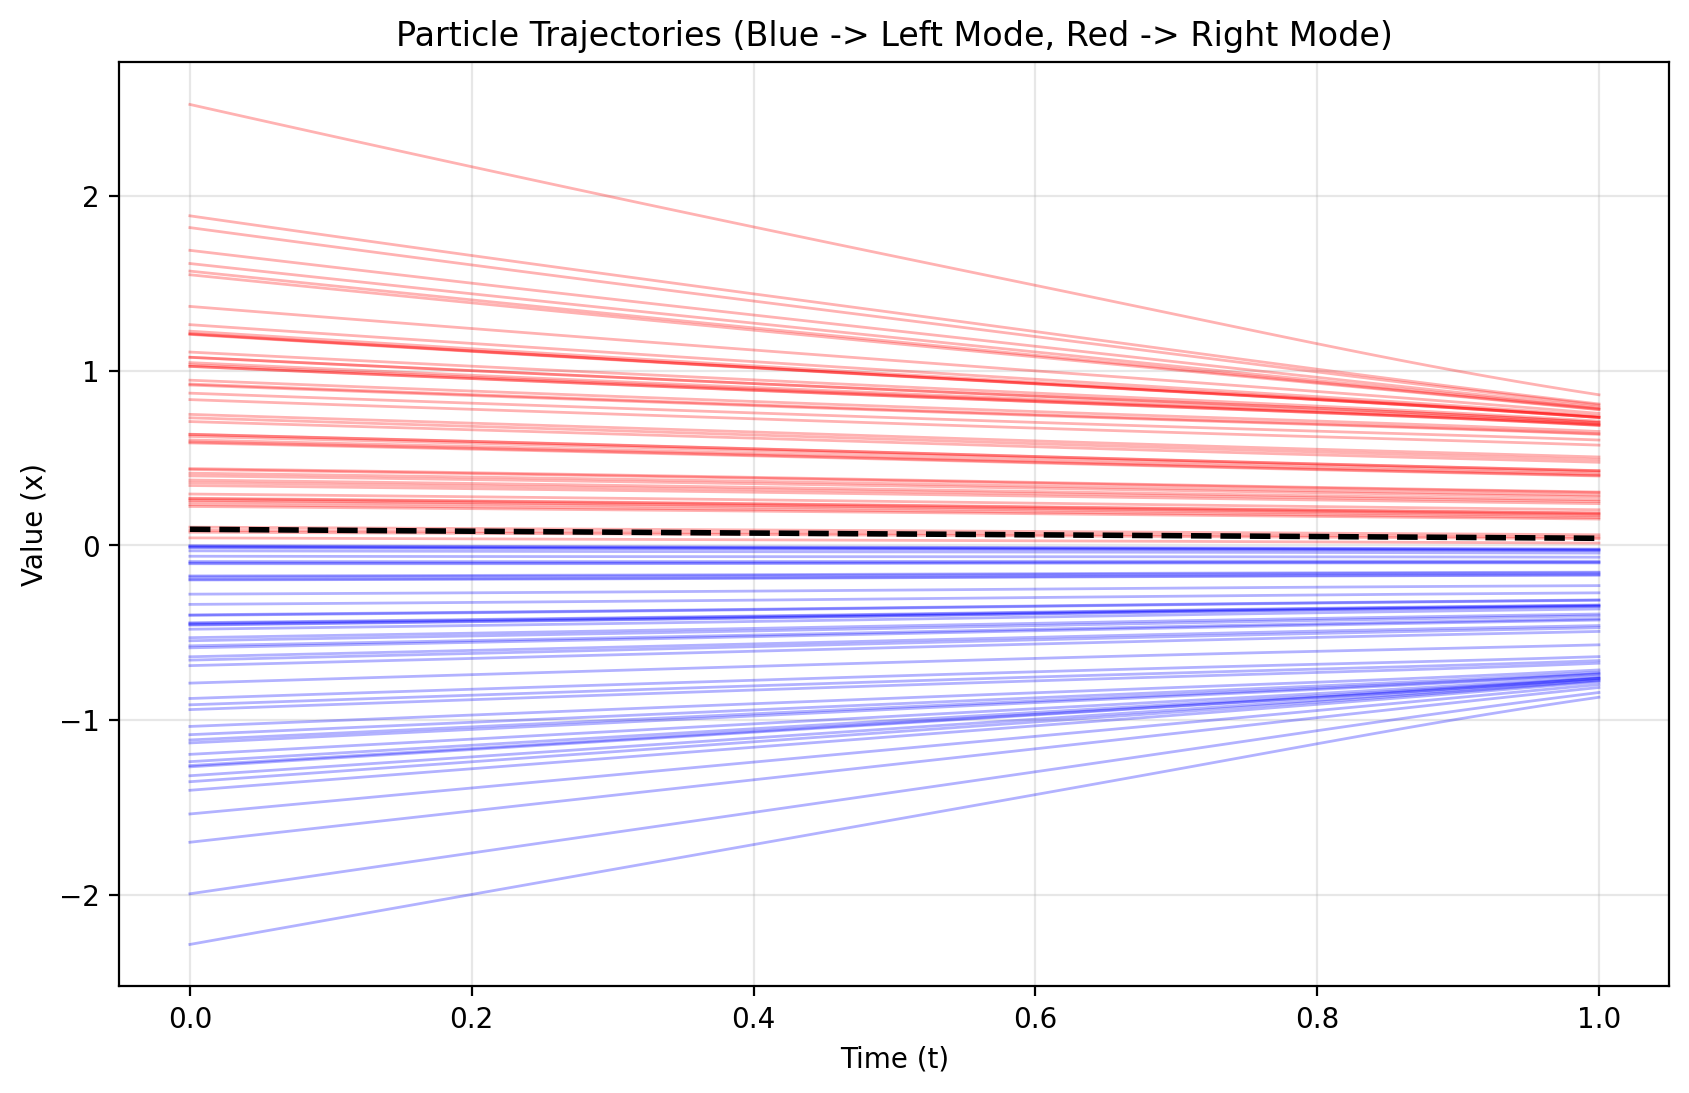

In [9]:
# CELL 7 - DEBUG VISUALIZATION
import matplotlib.pyplot as plt

# 1. Generate Trajectories
# We use a small batch to see individual lines clearly
debug_traj = flow_model.sample(batch_size=100, image_shape=(1,), num_steps=50, verbose=False)

# 2. Plot Lines (Time on X-axis, Value on Y-axis)
plt.figure(figsize=(10, 6))

# Plot every trajectory as a thin line
# debug_traj is List[Tensor(B, 1)] -> Convert to Array (Steps, B)
import numpy as np
traj_array = np.array([t.numpy().flatten() for t in debug_traj]) # Shape (Steps, B)
steps = np.linspace(0, 1, len(debug_traj))

# Plot lines
for i in range(traj_array.shape[1]):
    # Color lines based on their FINAL position (to see if they cross)
    color = 'red' if traj_array[-1, i] > 0 else 'blue'
    plt.plot(steps, traj_array[:, i], c=color, alpha=0.3, linewidth=1)

# Plot Mean Trajectory (Should stay near 0 if symmetric)
plt.plot(steps, traj_array.mean(axis=1), 'k--', linewidth=2, label='Mean Path')

plt.title("Particle Trajectories (Blue -> Left Mode, Red -> Right Mode)")
plt.xlabel("Time (t)")
plt.ylabel("Value (x)")
plt.grid(True, alpha=0.3)
plt.show()